### Milestone 2

#### Introduction

Nama : Galih Sukmanaputra  

Batch : FTDS-005-HCK  

Dataset : From https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images. It presented the classes of cancer on human chest.  

Background : Detecting lung cancer is crucial for several reasons, as it plays a significant role in improving patient outcomes and overall public health. Early detection empowers individuals to seek timely medical intervention and potentially improves their chances of successful treatment and long-term survival.


Objective : Building the image classification to classified each characteristic of cancer.

An Explanation for each classes : 

- **Adenocarcinoma**: This is the most common type of lung cancer, accounting for about 40% of cases. It typically develops in the outer regions of the lungs and is frequently observed in non-smokers. Adenocarcinoma may appear as a solid tumor or as small nodules. It tends to grow more slowly compared to other types and can occur in people of any age.
- **Squamous cell carcinoma**: Also known as epidermoid carcinoma, squamous cell carcinoma accounts for approximately 25-30% of lung cancer cases. It often develops in the central airways of the lungs, such as the bronchi. Squamous cell carcinoma is strongly associated with smoking and is more common in men. It can cause symptoms such as coughing, chest pain, and coughing up blood.
- Large cell carcinoma: This type of lung cancer is less common, making up about 10-15% of NSCLC cases. Large cell carcinoma gets its name from the appearance of the cancer cells under a microscope. It tends to grow and spread quickly, and it is often found in the outer regions of the lungs. It can be challenging to treat, as it does not respond well to targeted therapies.

#### Import Library

In [1]:
import os
import glob 
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers, optimizers
from os import listdir
from os.path import isdir, isfile, join
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import shutil
warnings.filterwarnings('ignore')

#### Data Loading

In [2]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle 

!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

In [3]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 99% 117M/119M [00:01<00:00, 83.4MB/s]
100% 119M/119M [00:01<00:00, 75.6MB/s]


using kaggle token

In [4]:
!unzip -q /content/chest-ctscan-images.zip -d images

In [5]:
# #removing .ipynb checkpoints on train dir
# path_ipynb_cp = '/content/images/Data/train/.ipynb_checkpoints'

# os.path.exists(path_ipynb_cp)

In [6]:
# shutil.rmtree(path_ipynb_cp)


In [7]:
# os.path.exists(path_ipynb_cp)

In [8]:
# #removing .ipynb checkpoints on val dir
# path_ipynb_cp2 = '/content/images/Data/valid/.ipynb_checkpoints'

# os.path.exists(path_ipynb_cp2)

In [9]:
# shutil.rmtree(path_ipynb_cp2)

In [10]:
main_path= '/content/images/Data' 
os.listdir(main_path)

['valid', 'train', 'test']

definining 3 type of dataset on main path

In [11]:
train_dir = os.path.join(main_path, 'train') 
val_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

print(train_dir)

/content/images/Data/train


In [12]:
#train
old ='/content/images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
new ='/content/images/Data/train/adenocarcinoma'
os.rename(old, new)

In [13]:
#train
old2 = '/content/images/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
new2 = '/content/images/Data/train/large.cell.carcinoma'
os.rename(old2, new2)

In [14]:
#train
old3 = '/content/images/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
new3 = '/content/images/Data/train/squamous.cell.carcinoma'
os.rename(old3, new3)

In [15]:
old_val = '/content/images/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
new_val = '/content/images/Data/valid/adenocarcinoma'
os.rename(old_val, new_val)

In [16]:
old_val2 = '/content/images/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
new_val2 = '/content/images/Data/valid/large.cell.carcinoma'
os.rename(old_val2, new_val2)

In [17]:
old_val3 = '/content/images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
new_val3 = '/content/images/Data/valid/squamous.cell.carcinoma'
os.rename(old_val3, new_val3)

renaming directory using os function

In [18]:
#direktori folder harus di rename terlebih dahulu 
def check_dir(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'total {label} : {num_data}')

print('train set: \n' + '='*50) 
check_dir(train_dir,['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma'])

print('val set: \n' + '='*50) 
check_dir(val_dir,['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma'])

print('\ntest set: \n' + '='*50) 
check_dir(test_dir,['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma'])

train set: 
total adenocarcinoma : 195
total large.cell.carcinoma : 115
total normal : 148
total squamous.cell.carcinoma : 155
val set: 
total adenocarcinoma : 23
total large.cell.carcinoma : 21
total normal : 13
total squamous.cell.carcinoma : 15

test set: 
total adenocarcinoma : 120
total large.cell.carcinoma : 51
total normal : 54
total squamous.cell.carcinoma : 90


looks that classes in each directory imbalanced

In [19]:
train_adenocarcinoma= glob.glob(train_dir + '/adenocarcinoma/*.png')
train_large_cell_carcinoma = glob.glob(train_dir + '/large.cell.carcinoma/*.png')
train_normal = glob.glob(train_dir + '/normal/*.png')
train_squamous_cell_carcinoma = glob.glob(train_dir + '/squamous.cell.carcinoma/*.png')

val_adenocarcinoma= glob.glob(val_dir + '/adenocarcinoma/*.png')
val_large_cell_carcinoma = glob.glob(val_dir + '/large.cell.carcinoma/*.png')
val_normal = glob.glob(val_dir + '/normal/*.png')
val_squamous_cell_carcinoma = glob.glob(val_dir + '/squamous.cell.carcinoma/*.png')

test_adenocarcinoma= glob.glob(test_dir + '/adenocarcinoma/*.png')
test_large_cell_carcinoma = glob.glob(test_dir + '/large.cell.carcinoma/*.png')
test_normal = glob.glob(test_dir + '/normal/*.png')
test_squamous_cell_carcinoma = glob.glob(test_dir + '/squamous.cell.carcinoma/*.png')


In [20]:
# #removing .ipynb checkpoints on train dir
# path_ipynb_cp = '/content/images/Data/train/.ipynb_checkpoints'

# os.path.exists(path_ipynb_cp)

In [21]:
# shutil.rmtree(path_ipynb_cp)

In [22]:
# #removing .ipynb checkpoints on val dir
# path_ipynb_cp2 = '/content/images/Data/valid/.ipynb_checkpoints'

# os.path.exists(path_ipynb_cp2)

In [23]:
# shutil.rmtree(path_ipynb_cp2)

In [24]:
train_adenocarcinoma[:6]

['/content/images/Data/train/adenocarcinoma/000025 (6).png',
 '/content/images/Data/train/adenocarcinoma/ad7.png',
 '/content/images/Data/train/adenocarcinoma/000018 (5).png',
 '/content/images/Data/train/adenocarcinoma/000050 (7).png',
 '/content/images/Data/train/adenocarcinoma/000058 (4).png',
 '/content/images/Data/train/adenocarcinoma/000054 (6).png']

#### EDA

- Checking shape of image. 
- Labels count. 
- Checking anomali pictures. 


In [25]:
def random_sample(image_files, num_samples=5):
  random_files= random.sample(image_files, num_samples)
  return random_files

In [33]:
random_train_adenocarcinoma = random_sample(train_adenocarcinoma)
random_train_large_cell_carcinoma = random_sample(train_large_cell_carcinoma)
random_train_normal = random_sample(train_normal)
random_train_squamous_cell_carcinoma = random_sample(train_adenocarcinoma)

In [27]:
random_train_adenocarcinoma

['/content/images/Data/train/adenocarcinoma/ad8.png',
 '/content/images/Data/train/adenocarcinoma/000049 (9).png',
 '/content/images/Data/train/adenocarcinoma/ad3.png',
 '/content/images/Data/train/adenocarcinoma/000005 (3).png',
 '/content/images/Data/train/adenocarcinoma/000008 (10).png']

In [28]:
!mkdir copy_img

In [29]:
img = plt.imread('/content/images/Data/train/adenocarcinoma/000069 (6).png')
print(img.shape)

(289, 418, 4)


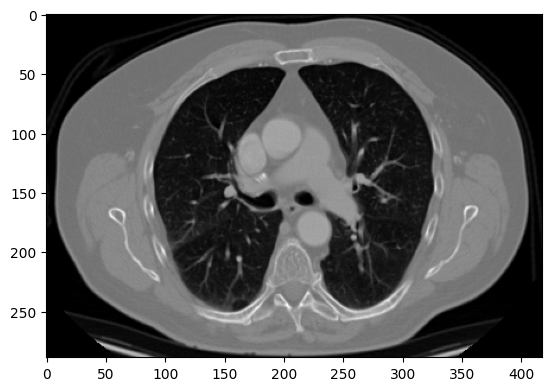

In [30]:
plt.imshow(img)

In [31]:
def visualize_img(random_data, labels=None):
  fig, axes= plt.subplots(1,5, figsize=(15,12))
  for i, image_path in enumerate(random_data):
    image= plt.imread(image_path)
    axes[i].imshow(image, cmap='gray') # bisa tanpa cmap kalau bener2 RGB
    axes[i].set_title(f'{labels}, {image.shape}')
    axes[i].axis('off')
  plt.show()

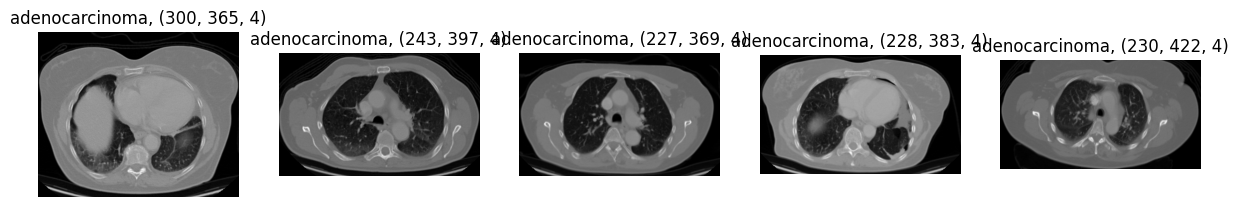

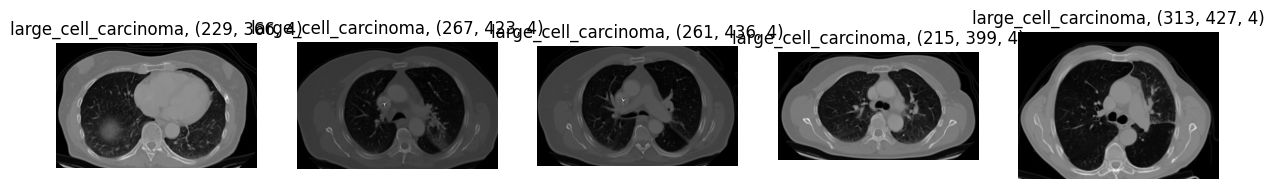

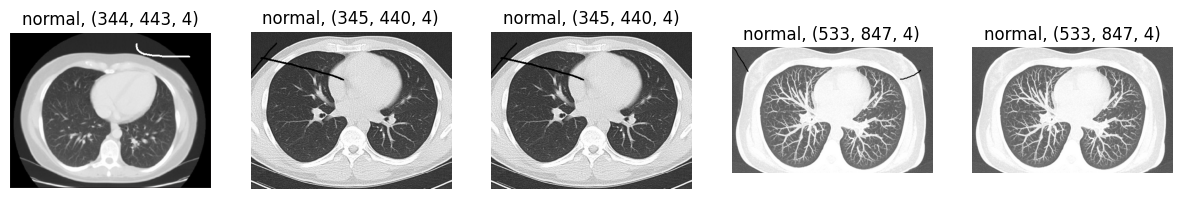

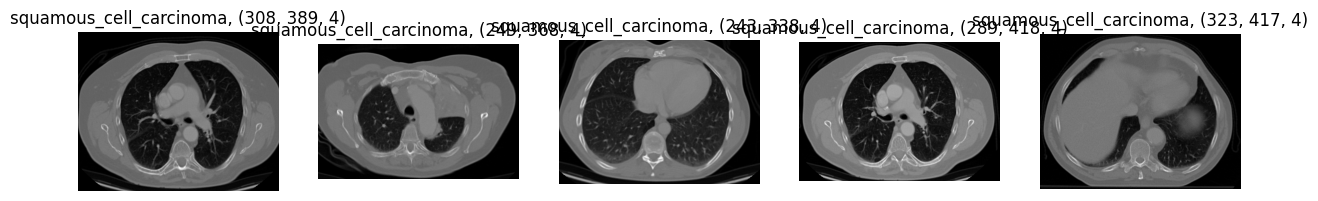

In [34]:
visualize_img(random_train_adenocarcinoma, 'adenocarcinoma')
visualize_img(random_train_large_cell_carcinoma, 'large_cell_carcinoma')
visualize_img(random_train_normal, 'normal')
visualize_img(random_train_squamous_cell_carcinoma, 'squamous_cell_carcinoma')


For those visualization every classes of each directory looks visible enough based on their position and others

In [35]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_adenocarcinoma + train_large_cell_carcinoma + train_normal + train_squamous_cell_carcinoma)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

val_df = create_dataframe(val_adenocarcinoma + val_large_cell_carcinoma + val_normal + val_squamous_cell_carcinoma)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_df = create_dataframe(test_adenocarcinoma + test_large_cell_carcinoma + test_normal + test_squamous_cell_carcinoma)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
print(train_df.shape)
train_df.head()

(601, 2)


images                    label
0  /content/images/Data/train/adenocarcinoma/0001...           adenocarcinoma
1  /content/images/Data/train/normal/4 - Copy - C...                   normal
2  /content/images/Data/train/squamous.cell.carci...  squamous.cell.carcinoma
3  /content/images/Data/train/adenocarcinoma/0000...           adenocarcinoma
4  /content/images/Data/train/adenocarcinoma/0000...           adenocarcinoma

In [37]:
print(val_df.shape)
val_df.head()

(72, 2)


images                    label
0  /content/images/Data/valid/adenocarcinoma/0001...           adenocarcinoma
1  /content/images/Data/valid/squamous.cell.carci...  squamous.cell.carcinoma
2  /content/images/Data/valid/adenocarcinoma/0001...           adenocarcinoma
3  /content/images/Data/valid/adenocarcinoma/0001...           adenocarcinoma
4  /content/images/Data/valid/large.cell.carcinom...     large.cell.carcinoma

In [38]:
print(test_df.shape)
test_df.head()

(315, 2)


images                 label
0            /content/images/Data/test/normal/23.png                normal
1  /content/images/Data/test/adenocarcinoma/00012...        adenocarcinoma
2  /content/images/Data/test/large.cell.carcinoma...  large.cell.carcinoma
3  /content/images/Data/test/adenocarcinoma/00015...        adenocarcinoma
4  /content/images/Data/test/adenocarcinoma/00012...        adenocarcinoma

Defining into dataframe

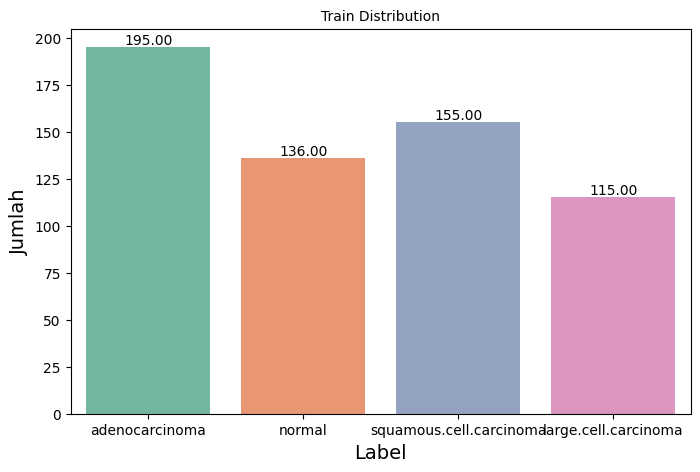

In [39]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

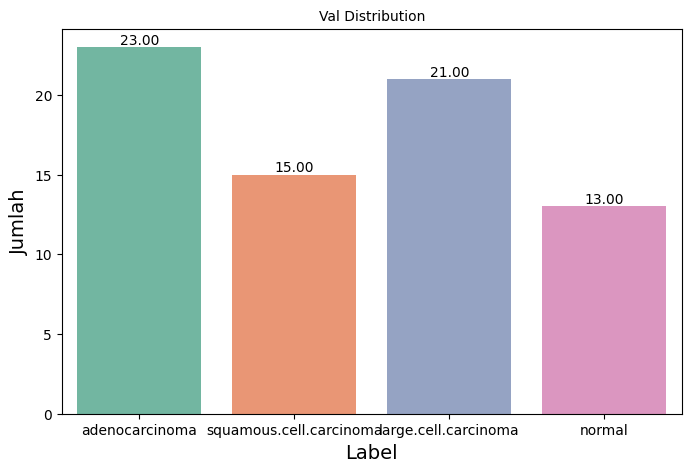

In [40]:
visualize_data(val_df, 'Val')

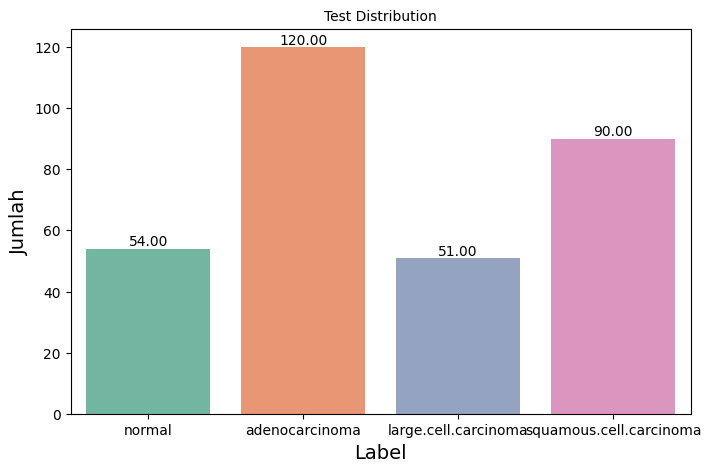

In [41]:
visualize_data(test_df, 'Test')

Every directory has a different amount for each classes

#### Preprocess

In [42]:
img_height= 224
img_width= 224
batch_size= 64
target_sizes = (img_height, img_width)

In [43]:
generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    rescale=1./255,
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

# val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
#     validation_split=0.15
# )

In [44]:
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(target_sizes),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42

)

Found 601 validated image filenames belonging to 4 classes.


In [45]:
val_images = generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(target_sizes),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,

)

Found 72 validated image filenames belonging to 4 classes.


In [46]:
test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(target_sizes),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 315 validated image filenames belonging to 4 classes.


#### Modeling

In [55]:
input_shape = (224,224, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (5,5), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (5,5)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (3,3)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 8)          0

In [56]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_images, validation_data=val_images, epochs=20, callbacks=callback)

Epoch 1/20
38/38 [==============================] - 24s 308ms/step - loss: 1.3727 - accuracy: 0.2629 - val_loss: 1.3667 - val_accuracy: 0.1806
Epoch 2/20
38/38 [==============================] - 11s 295ms/step - loss: 1.3282 - accuracy: 0.3527 - val_loss: 1.3049 - val_accuracy: 0.4167
Epoch 3/20
38/38 [==============================] - 12s 320ms/step - loss: 1.1883 - accuracy: 0.4426 - val_loss: 1.0395 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 11s 292ms/step - loss: 1.1209 - accuracy: 0.4975 - val_loss: 1.0908 - val_accuracy: 0.4722
Epoch 5/20
38/38 [==============================] - 10s 273ms/step - loss: 1.0633 - accuracy: 0.4859 - val_loss: 1.0466 - val_accuracy: 0.4861
Epoch 6/20
38/38 [==============================] - 11s 291ms/step - loss: 1.0422 - accuracy: 0.5158 - val_loss: 0.9678 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 11s 290ms/step - loss: 1.0622 - accuracy: 0.4842 - val_loss: 1.0041 - val_accuracy: 0.5000

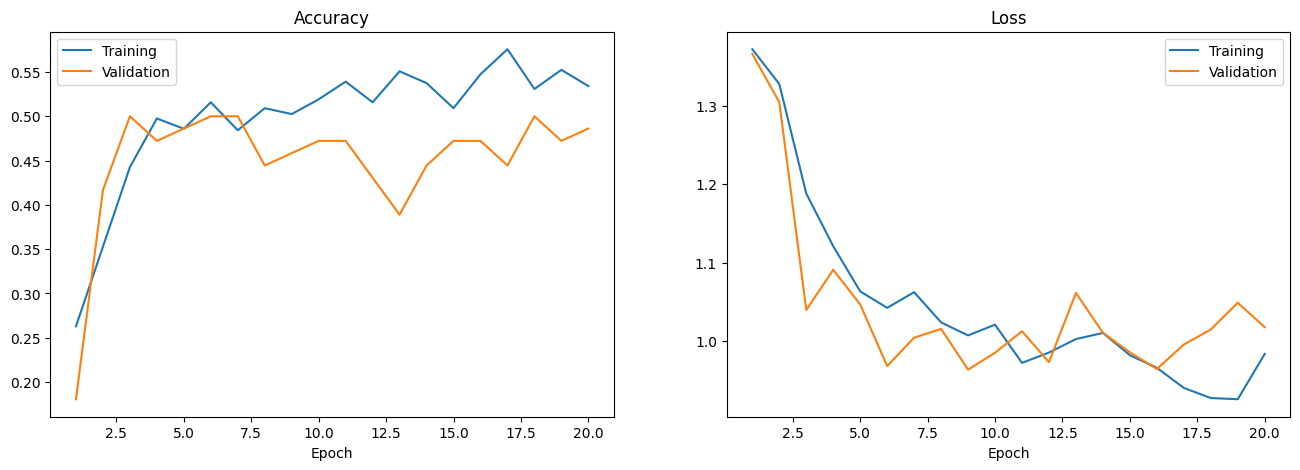

In [57]:
epochs=20

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history.history['accuracy'],label='Training')
ax[0].plot(range(1,epochs+1),history.history['val_accuracy'],label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(range(1,epochs+1),history.history['loss'],label='Training')
ax[1].plot(range(1,epochs+1),history.history['val_loss'],label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

overfit indicated with gradient problem

In [58]:
#  Sequential base evaluation
print("Evaluate on test data")
results = model.evaluate(test_images)
print(f'Test Loss     : {results[0]:.4f}')
print(f'Test Accuracy : {results[1]:.4f}')
print('')

Evaluate on test data
20/20 [==============================] - 6s 280ms/step - loss: 0.9775 - accuracy: 0.5206
Test Loss     : 0.9775
Test Accuracy : 0.5206



#### Tuning with-Normalization

In [59]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 44, 44, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        12832     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 32)       128       
 hNormalization)                                                 
                                                      

In [60]:
# optimizer_tune
model_tune.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history_tune = model_tune.fit(train_images, validation_data=val_images, epochs=20, callbacks=callback)

Epoch 1/20
38/38 [==============================] - 17s 342ms/step - loss: 1.3950 - accuracy: 0.3960 - val_loss: 1.3129 - val_accuracy: 0.3056
Epoch 2/20
38/38 [==============================] - 11s 292ms/step - loss: 1.2906 - accuracy: 0.4276 - val_loss: 1.4495 - val_accuracy: 0.2361
Epoch 3/20
38/38 [==============================] - 11s 284ms/step - loss: 1.1845 - accuracy: 0.4592 - val_loss: 1.4612 - val_accuracy: 0.2361
Epoch 4/20
38/38 [==============================] - 10s 263ms/step - loss: 1.1360 - accuracy: 0.4759 - val_loss: 1.7825 - val_accuracy: 0.2083
Epoch 5/20
38/38 [==============================] - 13s 334ms/step - loss: 1.0830 - accuracy: 0.4992 - val_loss: 1.4910 - val_accuracy: 0.2361
Epoch 6/20
38/38 [==============================] - 11s 287ms/step - loss: 1.0913 - accuracy: 0.5025 - val_loss: 1.4526 - val_accuracy: 0.3056
Epoch 7/20
38/38 [==============================] - 11s 293ms/step - loss: 1.0373 - accuracy: 0.5408 - val_loss: 1.4443 - val_accuracy: 0.3750

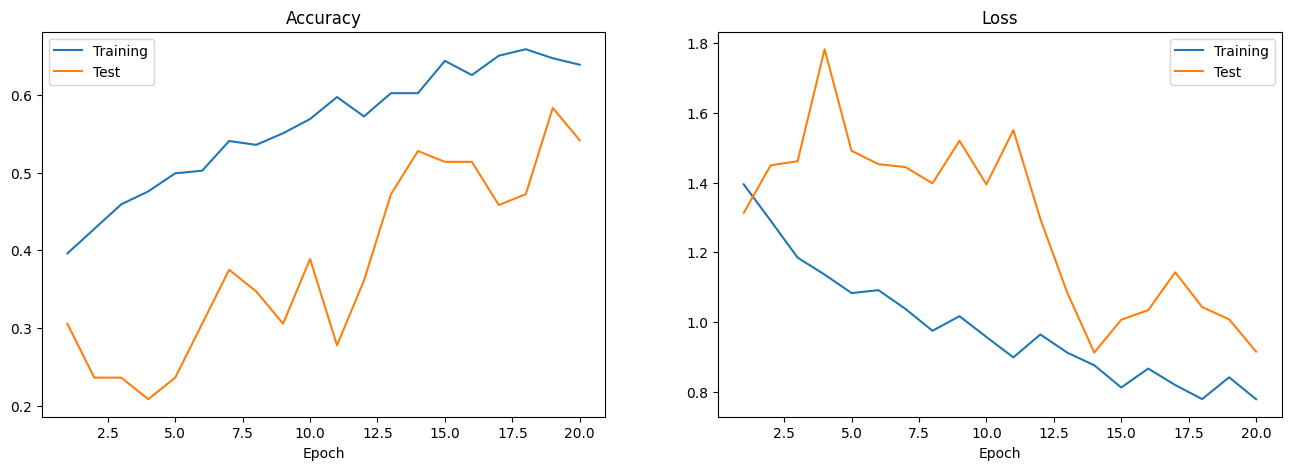

In [61]:
epochs=20

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epochs+1),history_tune.history['accuracy'],label='Training')
ax[0].plot(range(1,epochs+1),history_tune.history['val_accuracy'],label='Test')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(range(1,epochs+1),history_tune.history['loss'],label='Training')
ax[1].plot(range(1,epochs+1),history_tune.history['val_loss'],label='Test')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

In [62]:
#  Sequential tune evaluation
print("Evaluate on test data")
results = model_tune.evaluate(test_images)
print(f'Test Loss     : {results[0]:.4f}')
print(f'Test Accuracy : {results[1]:.4f}')
print('')

Evaluate on test data
20/20 [==============================] - 6s 299ms/step - loss: 0.9369 - accuracy: 0.5048
Test Loss     : 0.9369
Test Accuracy : 0.5048



In [63]:
pred = model_tune.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = train_images.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

20/20 [==============================] - 6s 267ms/step
{0: 'adenocarcinoma', 1: 'large.cell.carcinoma', 2: 'normal', 3: 'squamous.cell.carcinoma'}
[0 1 1 0 3 0 0 0 0 3 1 2 1 1 1 2 2 0 3 1 0 0 3 1 0 3 0 0 0 0 0 1 1 1 3 3 1
 1 0 0 2 3 0 0 1 0 1 2 2 1 0 0 2 1 1 0 3 0 0 2 0 2 0 2 0 1 1 0 1 1 1 3 2 0
 3 0 1 0 0 1 3 3 0 3 0 3 0 2 3 0 0 0 1 2 0 3 0 1 0 2 0 1 1 1 2 3 3 1 0 0 0
 2 1 3 0 0 1 0 0 1 0 0 1 2 0 3 2 1 0 1 2 0 3 2 0 1 0 1 2 0 3 0 0 3 2 0 0 2
 0 0 0 2 2 2 1 0 1 2 0 3 0 1 1 0 3 0 3 1 1 0 2 0 0 3 2 1 1 1 0 0 0 1 0 2 1
 0 0 3 0 2 0 0 3 3 1 0 3 1 2 1 0 3 0 2 0 0 2 0 1 0 1 1 2 1 0 0 1 1 1 3 0 1
 1 2 0 0 0 0 0 2 0 1 1 0 0 3 1 0 3 0 0 3 1 0 1 1 1 1 3 0 0 2 2 1 3 0 3 3 2
 3 0 1 2 0 1 1 0 1 0 2 3 1 1 1 0 0 0 0 3 1 0 1 0 3 1 1 2 2 3 2 3 0 0 0 0 1
 0 0 2 0 0 3 1 1 0 3 2 1 0 1 2 1 1 3 0]


                         precision    recall  f1-score   support

         adenocarcinoma       0.48      0.52      0.50       120
   large.cell.carcinoma       0.39      0.69      0.50        51
                 normal       0.98      0.87      0.92        54
squamous.cell.carcinoma       0.58      0.32      0.41        90

               accuracy                           0.55       315
              macro avg       0.61      0.60      0.58       315
           weighted avg       0.58      0.55      0.55       315

--------------------------------
[[62 40  1 17]
 [12 35  0  4]
 [ 3  4 47  0]
 [51 10  0 29]]
--------------------------------


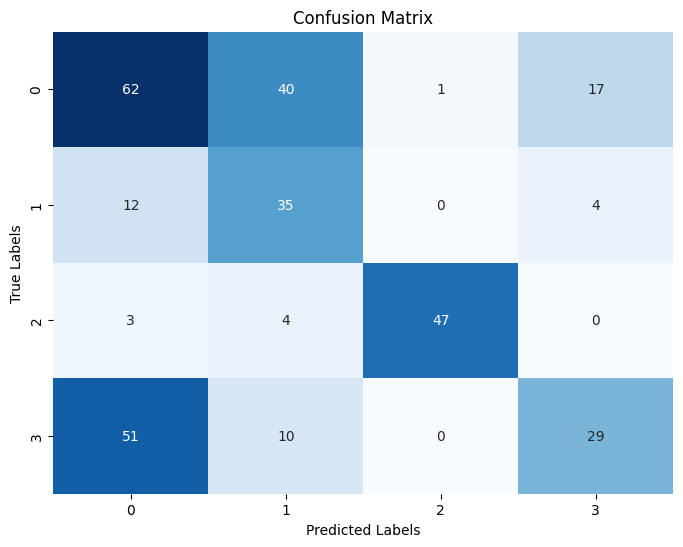

In [64]:
y_pred = [labels[k] for k in pred]

# Generate classification report
report = classification_report(test_df.label, y_pred)
print(report)
print('--------------------------------')

# Generate confusion matrix
matrix = confusion_matrix(test_df.label, y_pred)
print(matrix)
print('--------------------------------')

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



#### Transfer Learning

In [65]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience= 3),
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True)
]
from tensorflow.keras.applications.inception_v3 import InceptionV3

pretrained_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                  input_shape=input_shape,pooling='avg')
pretrained_model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [66]:
model_tf= Sequential()
model_tf.add(pretrained_model)

#fully connected layer
model_tf.add(Flatten())
model_tf.add(Dense(64, activation='relu')),
model_tf.add(Dense(units=4,activation='softmax'))

In [67]:
model_tf.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
model_tf.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 21,934,180
Trainable params: 131,396
Non-trainable params: 21,802,784
_________________________________________________________________


In [69]:
epochs= 20
history_tf= model_tf.fit(
    train_images,
    validation_data= val_images,
    epochs=epochs
)

Epoch 1/20
38/38 [==============================] - 21s 403ms/step - loss: 1.2761 - accuracy: 0.4459 - val_loss: 0.9931 - val_accuracy: 0.5417
Epoch 2/20
38/38 [==============================] - 12s 314ms/step - loss: 0.9108 - accuracy: 0.5857 - val_loss: 0.9935 - val_accuracy: 0.5694
Epoch 3/20
38/38 [==============================] - 13s 330ms/step - loss: 0.8326 - accuracy: 0.6156 - val_loss: 0.8906 - val_accuracy: 0.6111
Epoch 4/20
38/38 [==============================] - 11s 298ms/step - loss: 0.7587 - accuracy: 0.6389 - val_loss: 0.9277 - val_accuracy: 0.5972
Epoch 5/20
38/38 [==============================] - 14s 359ms/step - loss: 0.7120 - accuracy: 0.7072 - val_loss: 0.9528 - val_accuracy: 0.5139
Epoch 6/20
38/38 [==============================] - 12s 315ms/step - loss: 0.6678 - accuracy: 0.7072 - val_loss: 0.9711 - val_accuracy: 0.5417
Epoch 7/20
38/38 [==============================] - 12s 305ms/step - loss: 0.6657 - accuracy: 0.7288 - val_loss: 0.9419 - val_accuracy: 0.5139

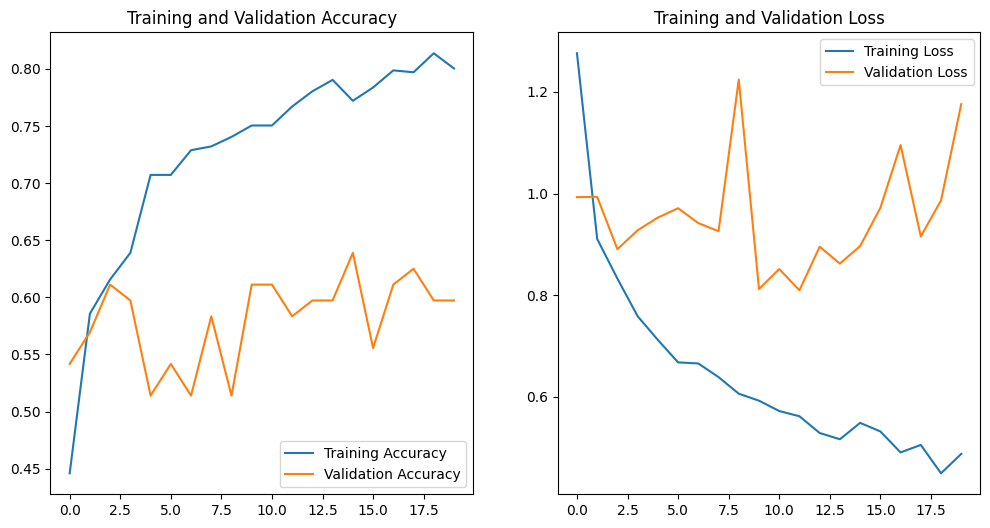

In [70]:
acc = history_tf.history['accuracy']
val_acc = history_tf.history['val_accuracy']

loss = history_tf.history['loss']
val_loss = history_tf.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
test_results_tf = model_tf.evaluate(test_images, verbose=0)
print(f'Test Loss     : {test_results_tf[0]:.4f}')
print(f'Test Accuracy : {test_results_tf[1]:.4f}')

Test Loss     : 0.9813
Test Accuracy : 0.6032


In [72]:
pred_tf = model_tf.predict(test_images)
pred_tf = np.argmax(pred_tf, axis=1)

labels_tf = train_images.class_indices
labels_tf = dict((v,k) for k, v in labels_tf.items())

print(labels_tf)
print(pred_tf)

20/20 [==============================] - 7s 316ms/step
{0: 'adenocarcinoma', 1: 'large.cell.carcinoma', 2: 'normal', 3: 'squamous.cell.carcinoma'}
[0 3 1 0 3 3 3 3 0 3 1 2 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 1 3 3 3 1
 1 3 0 2 0 1 0 0 3 0 2 2 3 0 3 2 3 1 0 3 3 3 2 2 2 3 0 1 1 3 3 3 3 3 0 2 0
 1 2 3 3 3 3 0 3 3 0 3 1 3 2 3 0 3 3 3 2 0 3 3 3 3 2 3 0 3 3 1 3 3 3 0 0 1
 2 3 3 1 0 0 0 3 2 3 1 0 2 3 1 2 1 1 1 2 0 3 2 3 3 3 1 1 3 3 1 3 3 2 3 1 2
 0 3 3 2 2 2 0 3 1 2 1 3 0 3 0 3 3 0 3 0 3 3 2 1 3 3 2 1 3 3 3 3 0 3 1 2 3
 3 3 1 3 2 3 0 0 3 1 3 3 1 2 3 3 3 3 2 2 0 2 3 3 0 0 0 2 3 3 3 2 3 3 3 0 1
 0 2 3 3 3 1 3 2 1 1 0 0 0 3 0 3 3 1 0 3 1 0 2 3 0 3 3 3 3 2 2 3 3 1 3 3 2
 0 0 2 2 3 3 0 3 0 0 2 0 3 3 3 3 1 0 0 3 1 3 3 0 3 3 3 2 2 3 2 1 0 3 3 1 3
 0 3 2 1 0 1 3 3 1 3 2 3 1 3 2 1 3 3 1]


                         precision    recall  f1-score   support

         adenocarcinoma       0.48      0.52      0.50       120
   large.cell.carcinoma       0.39      0.69      0.50        51
                 normal       0.98      0.87      0.92        54
squamous.cell.carcinoma       0.58      0.32      0.41        90

               accuracy                           0.55       315
              macro avg       0.61      0.60      0.58       315
           weighted avg       0.58      0.55      0.55       315

--------------------------------
[[44 18  0 58]
 [ 4 23  0 24]
 [ 3  1 50  0]
 [ 8  7  2 73]]
--------------------------------


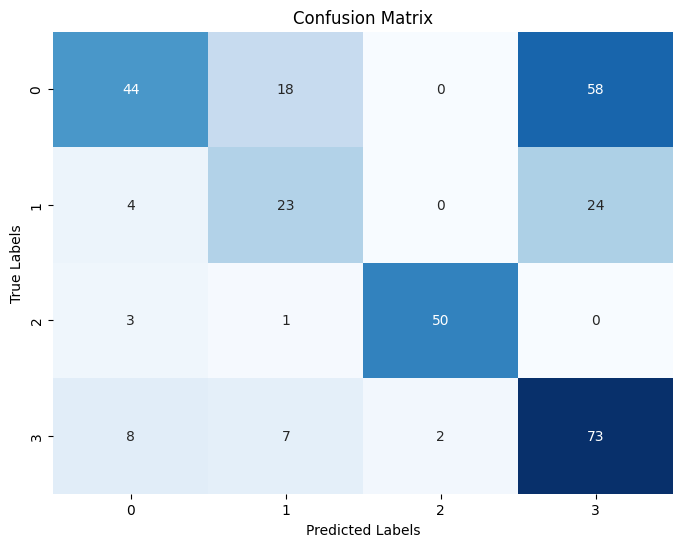

In [73]:
y_pred_tf = [labels_tf[k] for k in pred_tf]

# Generate classification report
report_tf = classification_report(test_df.label, y_pred_tf)
print(report)
print('--------------------------------')

# Generate confusion matrix
matrix_tf = confusion_matrix(test_df.label, y_pred_tf)
print(matrix_tf)
print('--------------------------------')

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_tf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Model Saving

In [74]:
model_tf.save('cnn_model.h5')